In [1]:
import os, random
import numpy as np
import pandas as pd
import bloscpack as bp
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.metrics import recall_score

import imgaug as ia
import imgaug.augmenters as iaa

import torch
from torch.utils.data.dataloader import DataLoader
from torch.nn.utils import clip_grad_value_
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from apex import amp

from optim import Over9000

from data import Bengaliai_DS
from models_mg import Simple50GeM
from mixup_pytorch_utils import MuCm, mixup_loss
from loss import CenterLoss, AngularPenaltySMLoss
import utils

import cv2
cv2.setNumThreads(1)


# =========================================================================================================================

SEED = 19841202

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)


# =========================================================================================================================

augs =  iaa.SomeOf(
    (0, 2),
    [
        iaa.OneOf(
            [
                iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, rotate=(-20, 20), shear=(-20, 20)),
                iaa.PerspectiveTransform(scale=.09, keep_size=True),
            ]
        ),
        iaa.PiecewiseAffine(scale=(0.02, 0.04)),
        # iaa.CoarseDropout(p=(.1, .2), size_percent=(.1, .2)),
        iaa.DirectedEdgeDetect(alpha=(.01, .99), direction=(0.0, 1.0)),
    ],
    random_order=True
)

# =========================================================================================================================

pdf = pd.read_csv('../input/train.csv')
pdf['combo'] = pdf.apply(lambda row: '_'.join([str(row['grapheme_root']), str(row['vowel_diacritic']), str(row['consonant_diacritic'])]), axis=1)
unique_grapheme = pdf['combo'].unique() # 1292
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['combo']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=19841202)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
trn_pdf = pdf.iloc[trn_ndx, :]
trn_pdf.reset_index(inplace=True, drop=True)
imgs = bp.unpack_ndarray_from_file('../features/train_images_size128_raw.bloscpack')
lbls = pdf.loc[:, ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme_code']].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx]


training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=None, scale=False, norm=False, RGB=False)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

batch_size = 64

training_loader = DataLoader(training_set, batch_size=batch_size, num_workers=4, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=4, shuffle=False)

In [3]:
for imgs, lbls in training_loader:
    break

In [20]:
trn_imgs_batch_device_mixup, trn_lbls_batch_device_shfl, gamma = MuCm(imgs, lbls)

In [21]:
gamma

tensor([0.7009, 0.9587, 0.7803, 0.5896, 0.9587, 0.9587, 0.9587, 0.9587, 0.8708,
        0.9587, 0.9375, 0.8474, 0.6475, 0.9587, 0.9587, 0.5693, 0.9587, 0.8818,
        0.6658, 0.9587, 0.6287, 0.6475, 0.9587, 0.9587, 0.9451, 0.9209, 0.9521,
        0.8923, 0.9119, 0.6287, 0.8818, 0.6475, 0.9587, 0.8350, 0.6836, 0.6287,
        0.9587, 0.9587, 0.5273, 0.9587, 0.9451, 0.8474, 0.9587, 0.9451, 0.6475,
        0.7341, 0.6475, 0.6287, 0.9587, 0.7500, 0.7500, 0.8086, 0.9521, 0.9023,
        0.8220, 0.9587, 0.7009, 0.5273, 0.9294, 0.5273, 0.9587, 0.9023, 0.6475,
        0.9587])

In [22]:
a = trn_imgs_batch_device_mixup.numpy()

In [10]:
import matplotlib.pyplot as plt

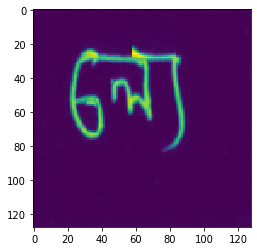

In [29]:
plt.imshow(a[1, 0])